In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install contractions
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 34.1 MB/s 
     |████████████████████████████████| 182 kB 72.6 MB/s 
     |████████████████████████████████| 7.6 MB 18.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 28.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 11.7 MB/s 
     |████████████████████████████████| 287 kB 59.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.1 MB/s 


In [ ]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.utils.data_utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

import contractions
import demoji
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training_df = pd.read_csv("/content/drive/My Drive/NLP Project/Data/Training Data.csv")
training_df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-4311,"Leftie Sjws ,simps and women eating it up. So ...",sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against...
1,sexism2022_english-8677,"Thank YOU Lord for favoring me! ""[Whoso] finde...",not sexist,none,none
2,sexism2022_english-19317,Another Democrat with signal eyeglasses.There ...,sexist,2. derogation,2.1 descriptive attacks
3,sexism2022_english-4631,I was 23. I met a girl on tinder and lost it. ...,not sexist,none,none
4,sexism2022_english-650,"Try 13. I witnessed a groups teenage girls, no...",not sexist,none,none


In [ ]:
testing_df = pd.read_csv("/content/drive/My Drive/NLP Project/Data/Testing Data.csv")
testing_df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
2,sexism2022_english-18627,There's also enough evidence to like Goldberg ...,not sexist,none,none
3,sexism2022_english-10099,fuck her off with a nine mm this is what you g...,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm
4,sexism2022_english-1525,Lefty dad offers daughter $100 to knock MAGA h...,not sexist,none,none


In [ ]:
training_df['text'] = training_df['text'].str.replace('`', "'") #consistent quotes
training_df['text'] = training_df['text'].str.replace('“', '"') #consistent quotes
training_df['text'] = training_df['text'].str.replace('”', '"') #consistent quotes

for i in range(len(training_df.axes[0])):
    training_df.iat[i,1] = contractions.fix(training_df.iat[i,1]) #remove contractions

training_df['text'] = training_df['text'].str.replace('[0-9]*', "", regex=True) #remove digits
training_df['text'] = training_df['text'].str.replace('\\[USER\\]|\\[URL\\]', "", regex=True) #remove "URL" and "USER"
training_df['text'] = training_df['text'].str.lower() #convert to lowercase

training_df['text'] = training_df['text'].str.replace(r'\u200d', "", regex=True)
training_df['text'] = training_df['text'].str.replace(r'\u200f', "", regex=True)
training_df['text'] = training_df['text'].str.replace(r'\u200b', "", regex=True)

punctuation = string.punctuation + "—"
stop_words = stopwords.words('english')
porter = PorterStemmer()

for i in range(len(training_df.axes[0])):
    text = training_df.iat[i,1]
    text = text.translate(str.maketrans(punctuation, ' '*len(punctuation), '')) #remove punctuations
    text = demoji.replace(text, "")
    training_df.iat[i,1] = text

In [ ]:
testing_df['text'] = testing_df['text'].str.replace('`', "'") #consistent quotes
testing_df['text'] = testing_df['text'].str.replace('“', '"') #consistent quotes
testing_df['text'] = testing_df['text'].str.replace('”', '"') #consistent quotes

for i in range(len(testing_df.axes[0])):
    testing_df.iat[i,1] = contractions.fix(testing_df.iat[i,1]) #remove contractions

testing_df['text'] = testing_df['text'].str.replace('[0-9]*', "", regex=True) #remove digits
testing_df['text'] = testing_df['text'].str.replace('\\[USER\\]|\\[URL\\]', "", regex=True) #remove "URL" and "USER"
testing_df['text'] = testing_df['text'].str.lower() #convert to lowercase

testing_df['text'] = testing_df['text'].str.replace(r'\u200d', "", regex=True)
testing_df['text'] = testing_df['text'].str.replace(r'\u200f', "", regex=True)
testing_df['text'] = testing_df['text'].str.replace(r'\u200b', "", regex=True)

punctuation = string.punctuation + "—"
stop_words = stopwords.words('english')
porter = PorterStemmer()

for i in range(len(testing_df.axes[0])):
    text = testing_df.iat[i,1]
    text = text.translate(str.maketrans(punctuation, ' '*len(punctuation), '')) #remove punctuations
    text = demoji.replace(text, "")
    testing_df.iat[i,1] = text

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

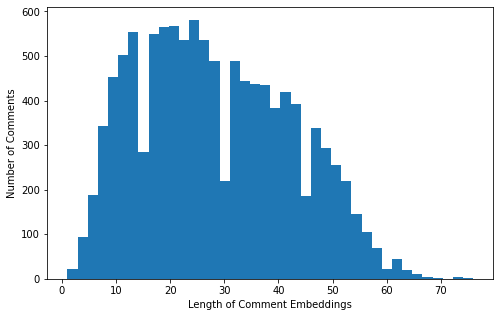

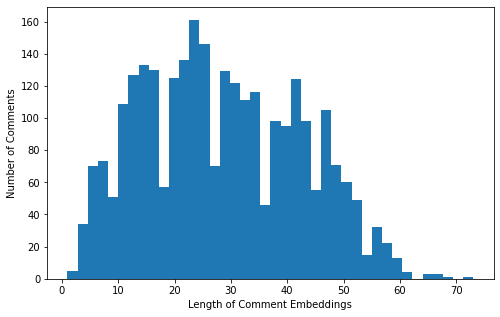

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
    
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

train_text_list = training_df["text"].values
test_text_list = testing_df["text"].values

plot_sentence_embeddings_length(train_text_list, tokenizer)

plot_sentence_embeddings_length(test_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=80)

In [ ]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=80)

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)

In [ ]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)

In [ ]:
# add input ids and attention masks to the dataframe
training_df["features"] = train_input_ids.tolist()
training_df["masks"] = train_attention_masks

testing_df["features"] = test_input_ids.tolist()
testing_df["masks"] = test_attention_masks

In [ ]:
sexist = []
not_sexist = []
for i in range(len(training_df.axes[0])):
  if training_df.iat[i,2] == "sexist":
    sexist.append(1)
    not_sexist.append(0)
  else:
    sexist.append(0)
    not_sexist.append(1)

training_df["sexist"] = sexist
training_df["not_sexist"] = not_sexist

In [ ]:
# train valid split
training_df, validating_df = train_test_split(training_df, test_size=0.2, random_state=42)

In [ ]:
X_train = training_df["features"].values.tolist()
X_valid = validating_df["features"].values.tolist()

train_masks = training_df["masks"].values.tolist()
valid_masks = validating_df["masks"].values.tolist()

label_cols = ["sexist", "not_sexist"]
Y_train = training_df[label_cols].values.tolist()
Y_valid = validating_df[label_cols].values.tolist()

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

<ipython-input-22-4f6268932cd1>:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_masks = torch.tensor(train_masks, dtype=torch.long)
<ipython-input-22-4f6268932cd1>:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  valid_masks = torch.tensor(valid_masks, dtype=torch.long)


In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
# #schedulaer = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
# num_epochs=3

# model_save_path = output_model_file = "/content/drive/My Drive/NLP Project/XLNet/Models/xlnet_toxic(80).bin"

# model, train_loss_set, valid_loss_set = train(model=model,\
#                                               num_epochs=num_epochs,\
#                                               optimizer=optimizer,\
#                                               train_dataloader=train_dataloader,\
#                                               valid_dataloader=validation_dataloader,\
#                                               model_save_path=model_save_path,\
#                                               device="cuda")

In [ ]:
# # Plot loss
# num_epochs = np.arange(len(train_loss_set))

# fig, ax = plt.subplots(figsize=(10, 5));
# ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
# ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# #ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
# ax.set_xlabel("Number of Epochs")
# ax.set_ylabel("Loss")
# ax.set_title("Loss vs Number of Epochs")

In [ ]:
model_save_path = output_model_file = "/content/drive/My Drive/NLP Project/XLNet/Models/xlnet_toxic(80).bin"
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [ ]:
# num_epochs=3
# model, train_loss_set, valid_loss_set = train(model=model,\
#                                               num_epochs=num_epochs,\
#                                               optimizer=optimizer,\
#                                               train_dataloader=train_dataloader,\
#                                               valid_dataloader=validation_dataloader,\
#                                               model_save_path=model_save_path,\
#                                               train_loss_set=train_loss_hist,\
#                                               valid_loss_set=valid_loss_hist,\
#                                               lowest_eval_loss=lowest_eval_loss,\
#                                               start_epoch=start_epoch,\
#                                               device="cuda")

In [ ]:
# # Plot loss
# num_epochs = np.arange(len(train_loss_set))

# fig, ax = plt.subplots(figsize=(10, 5));
# ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
# ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# #ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
# ax.set_xlabel("Number of Epochs")
# ax.set_ylabel("Loss")
# ax.set_title("Loss vs Number of Epochs")

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, testing_df, num_labels, device="cuda", batch_size=32)
pred_probs

<ipython-input-34-986738fbaa7e>:14: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.tensor(masks, dtype=torch.long)


array([[0.01389485, 0.98979491],
       [0.03033074, 0.96862417],
       [0.10426931, 0.90547401],
       ...,
       [0.02023092, 0.98007858],
       [0.35674757, 0.64232385],
       [0.0616569 , 0.95047802]])

In [ ]:
label_cols = ["sexist", "not_sexist"]

testing_df["sexist"] = pred_probs[:,0]
testing_df["not_sexist"] = pred_probs[:,1]

In [ ]:
test_to_csv = testing_df.reset_index()

In [ ]:
pred_save_path = output_model_file ="/content/drive/My Drive/NLP Project/XLNet/toxic_1_epoch(80).csv"
test_to_csv[["sexist", "not_sexist"]].to_csv(pred_save_path, index=False)

In [ ]:
y_pred = []
pred_probs_rounded = np.round(pred_probs)

for i in range(len(test_to_csv.axes[0])):
    if pred_probs_rounded[i][0] == 1:
      y_pred.append("sexist")
    else:
      y_pred.append("not sexist")

y_test = list(test_to_csv['label_sexist'])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred), ", F1 Macro:", metrics.f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.8610714285714286 , F1 Macro: 0.7694705038864285


With 250 embeddings, Accuracy: 0.8571428571428571, F1 Macro: 0.8045953588606234<br>
With 80 embeddings, Accuracy: 0.855, F1 Macro: 0.7831136997048149